In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

df = pd.read_csv('resources/data_v3.csv')

def parse_mixed_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except Exception:
        return pd.NaT

# df = df.iloc[:-8]
df['Scan date'] = df['Scan date'].astype(str).apply(parse_mixed_date)
df['Commit frequency'] = df['Commit frequency'].str.capitalize()
# df['Scan date'] = pd.to_datetime(df['Scan date'], errors='coerce', dayfirst=False)
label_map = {
    'Very low': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very high': 4
}
df['Evaluate'] = df["Evaluate"].map(label_map)



df_copy = df.loc[:, (df != 0).any(axis=0)]
df_copy = df_copy.drop(labels=['Sprint'], axis=1)

In [2]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 13 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Change code line number                                783 non-null    int64         
 1   Number of vulnerable modules                           783 non-null    int64         
 2   Number of people involved in development               783 non-null    int64         
 3   Time to complete each version                          783 non-null    object        
 4   Commit frequency                                       783 non-null    object        
 5   Type of environment                                    783 non-null    object        
 6   Number of libraries detected errors                    783 non-null    int64         
 7   Scan date                                              783 non-null    

In [3]:
df_copy

,Change code line number,Number of vulnerable modules,Number of people involved in development,Time to complete each version,Commit frequency,Type of environment,Number of libraries detected errors,Scan date,Number of potential weaknesses,Severity of the threat,Number of environmental configuration vulnerabilities,Evaluate,Repo
0,527,1,3,7 days,Daily,Cloud,15,2025-01-01,19,3,4,3,user-management
1,1505,1,2,7 days,Monthly,Cloud,45,2025-01-01,49,3,4,3,user-management
2,66,1,1,5 days,Monthly,Cloud,22,2025-01-01,26,4,4,2,admin-jlpt
3,1055,1,8,10 days,Weekly,Cloud,43,2025-01-01,46,4,3,2,payment-system
4,769,1,3,10 days,Daily,Cloud,32,2025-01-01,36,4,4,2,admin-jlpt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,131,1,3,7 days,Weekly,VPS,9,2023-02-17,14,2,5,1,Vue-trello
779,126,1,3,7 days,Weekly,VPS,9,2024-05-19,14,2,5,1,Vue-trello
780,129,1,3,7 days,Weekly,VPS,9,2023-02-24,14,2,5,1,Vue-trello
781,135,1,3,7 days,Weekly,VPS,9,2023-06-10,14,2,5,1,Vue-trello


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_timeseries_dataframe(df: pd.DataFrame):
    df = df.copy()
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.drop(labels=['Sprint'], axis=1)
    df['Scan date'] = pd.to_datetime(df['Scan date'])

    categorical_columns = ['Time to complete each version', 'Commit frequency', 'Type of environment', 'Repo']
    group_sum_col = 'Change code line number'
    target_col = 'Evaluate'
    date_col = 'Scan date'

    all_dfs = []
    for repo, group in df.groupby('Repo'):
        # group by date to avoid duplicates before reindexing
        group = group.groupby(date_col).agg({
            group_sum_col: 'sum',
            'Number of vulnerable modules': 'mean',
            'Number of people involved in development': 'mean',
            'Number of libraries detected errors': 'mean',
            'Number of potential weaknesses': 'mean',
            'Severity of the threat': 'mean',
            'Number of environmental configuration vulnerabilities': 'mean',
            target_col: 'first',
            **{col: 'first' for col in categorical_columns}
        }).sort_index()

        # create full date index and reindex
        all_dates = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
        group = group.reindex(all_dates, method='ffill')
        group[date_col] = group.index
        group['Repo'] = repo

        # identify filled-in rows and set code line to 0
        original_dates = df[df['Repo'] == repo]['Scan date'].unique()
        group[group_sum_col] = group[group_sum_col].where(group.index.isin(original_dates), 0)

        all_dfs.append(group)

    df_filled = pd.concat(all_dfs).reset_index(drop=True)

    # encode categoricals
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_filled[col] = le.fit_transform(df_filled[col])
        label_encoders[col] = le

    # normalize features (excluding Scan date, Repo, Evaluate)
    feature_cols = df_filled.columns.difference([date_col, 'Repo', target_col])
    scaler = StandardScaler()
    df_filled[feature_cols] = scaler.fit_transform(df_filled[feature_cols])

    # final outputs
    X = df_filled.drop(columns=[date_col, 'Repo', target_col])
    y = df_filled[target_col]
    meta = df_filled[[date_col, 'Repo']]

    return X, y, meta, label_encoders, scaler

In [5]:
X, y, meta, encoders, scaler = preprocess_timeseries_dataframe(df)
X

,Change code line number,Number of vulnerable modules,Number of people involved in development,Number of libraries detected errors,Number of potential weaknesses,Severity of the threat,Number of environmental configuration vulnerabilities,Time to complete each version,Commit frequency,Type of environment
0,0.324700,-0.298289,0.296948,0.266051,0.191212,1.373858,-0.408835,0.378975,0.402613,0.648087
1,1.077030,-0.298289,0.296948,0.266051,0.191212,1.373858,-0.408835,0.378975,0.402613,0.648087
2,-0.171837,-0.298289,0.296948,0.266051,0.191212,1.373858,-0.408835,0.378975,0.402613,0.648087
3,-0.200050,-0.298289,0.296948,0.266051,0.191212,1.373858,-0.408835,0.378975,0.402613,0.648087
4,-0.200050,-0.298289,0.296948,0.266051,0.191212,1.373858,-0.408835,0.378975,0.402613,0.648087
...,...,...,...,...,...,...,...,...,...,...
5117,-0.200050,-0.298289,0.872569,-0.949415,-1.088630,-1.197873,-1.414624,0.378975,0.402613,0.648087
5118,-0.200050,-0.298289,0.872569,-0.949415,-1.088630,-1.197873,-1.414624,0.378975,0.402613,0.648087
5119,-0.200050,-0.298289,0.872569,-0.949415,-1.088630,-1.197873,-1.414624,0.378975,0.402613,0.648087
5120,-0.200050,-0.298289,0.872569,-0.949415,-1.088630,-1.197873,-1.414624,0.378975,0.402613,0.648087


In [6]:
y

0       4
1       4
2       4
3       4
4       4
       ..
5117    0
5118    0
5119    0
5120    0
5121    0
Name: Evaluate, Length: 5122, dtype: int64

In [7]:
meta

,Scan date,Repo
0,2024-05-16,0
1,2024-05-17,0
2,2024-05-18,0
3,2024-05-19,0
4,2024-05-20,0
...,...,...
5117,2024-10-02,19
5118,2024-10-03,19
5119,2024-10-04,19
5120,2024-10-05,19


In [8]:
ori_X = scaler.inverse_transform(X[list(scaler.feature_names_in_)]).astype(int)
ori_X = pd.DataFrame(data=ori_X, columns=list(scaler.feature_names_in_))

In [9]:
for col in ('Time to complete each version', 'Commit frequency', 'Type of environment'):
    ori_X[col] = encoders[col].inverse_transform(ori_X[col])

In [10]:
ori_X

,Change code line number,Commit frequency,Number of environmental configuration vulnerabilities,Number of libraries detected errors,Number of people involved in development,Number of potential weaknesses,Number of vulnerable modules,Severity of the threat,Time to complete each version,Type of environment
0,279,Weekly,2,21,3,23,1,5,7 days,VPS
1,679,Weekly,2,21,3,23,1,5,7 days,VPS
2,15,Weekly,2,21,3,23,1,5,7 days,VPS
3,0,Weekly,2,21,3,23,1,5,7 days,VPS
4,0,Weekly,2,21,3,23,1,5,7 days,VPS
...,...,...,...,...,...,...,...,...,...,...
5117,0,Weekly,0,5,4,5,1,0,7 days,VPS
5118,0,Weekly,0,5,4,5,1,0,7 days,VPS
5119,0,Weekly,0,5,4,5,1,0,7 days,VPS
5120,0,Weekly,0,5,4,5,1,0,7 days,VPS


In [11]:
ori_meta  = meta.copy()
ori_meta['Repo'] = encoders['Repo'].inverse_transform(ori_meta['Repo'])
ori_meta

,Scan date,Repo
0,2024-05-16,6am_BE
1,2024-05-17,6am_BE
2,2024-05-18,6am_BE
3,2024-05-19,6am_BE
4,2024-05-20,6am_BE
...,...,...
5117,2024-10-02,web-hly
5118,2024-10-03,web-hly
5119,2024-10-04,web-hly
5120,2024-10-05,web-hly


In [12]:
ori_y = pd.DataFrame(data=y, columns=['Evaluate'])
ori_y

,Evaluate
0,4
1,4
2,4
3,4
4,4
...,...
5117,0
5118,0
5119,0
5120,0


In [13]:
col_names = list(ori_X.columns) + list(ori_meta.columns) + list(ori_y.columns)
ori_data = pd.concat([ori_X, ori_meta, ori_y], ignore_index=True, axis=1)
ori_data.columns = col_names
ori_data = ori_data[df_copy.columns.tolist()]
ori_data.to_csv('resources/data_cleaned_v3.csv', index=False)

### Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

class BayesianDense(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.w_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.b_mu = nn.Parameter(torch.Tensor(out_features))
        self.b_sigma = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.w_mu, mode='fan_in')
        nn.init.constant_(self.w_sigma, -3)
        nn.init.constant_(self.b_mu, 0.1)
        nn.init.constant_(self.b_sigma, -3)

    def forward(self, x):
        w = Normal(self.w_mu, torch.exp(self.w_sigma)).rsample()
        b = Normal(self.b_mu, torch.exp(self.b_sigma)).rsample()
        return F.linear(x, w, b)

class MyModel(nn.Module):
    def __init__(self, input_features=10, timesteps=5, num_classes=5):
        super().__init__()
        assert input_features == 10, 'only 10 features supported right now'

        self.input_dense = BayesianDense(input_features, 32)
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)

        self.bayesian_layers = nn.ModuleList([
            BayesianDense(64, 64),
            BayesianDense(64, 48),
            BayesianDense(48, 48),
            BayesianDense(48, 32)
        ])

        self.dropout = nn.Dropout(0.1)
        self.final_dense = BayesianDense(32, num_classes)

        self.swish = lambda x: x * torch.sigmoid(x)

    def forward(self, x):
        batch_size, T, _ = x.shape

        x = self.swish(self.input_dense(x))  # (batch, T, 32)
        lstm_out, _ = self.lstm(x)  # (batch, T, 64)

        x = lstm_out
        for layer in self.bayesian_layers:
            x = self.swish(layer(x))

        x = self.dropout(x)
        logits = self.final_dense(x)  # (batch, T, num_classes)
        return logits
    
def evaluate(model, loader, verbose=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            output = model(x_batch)  # (batch, T, num_classes)
            preds = output.argmax(dim=-1)
            all_preds.append(preds.flatten())
            all_labels.append(y_batch.flatten())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = (all_preds == all_labels).float().mean().item()
    if verbose:
        print(f"accuracy: {acc:.4f}")
    return acc

from sklearn.metrics import precision_recall_fscore_support

def train_model(model, train_loader, val_loader, device, epochs=200, lr=0.0001, verbose=True, patience=50):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_accuracies = [], []

    best_acc = 0
    best_metrics = {'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0}
    best_epoch = 0
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # eval
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                preds = output.argmax(dim=-1)
                all_preds.append(preds.flatten())
                all_labels.append(y_batch.flatten())
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        acc = (all_preds == all_labels).float().mean().item()
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels.cpu(), all_preds.cpu(), average='weighted', zero_division=0
        )

        val_accuracies.append(acc)
        if verbose:
            print(f'Epoch {epoch+1}: loss = {avg_loss:.4f}, A = {acc:.4f}, P = {precision:.4f}, R = {recall:.4f}, F1 = {f1:.4f}')

        if acc > best_acc:
            best_acc = acc
            best_metrics = {'acc': acc, 'precision': precision, 'recall': recall, 'f1': f1}
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}, best epoch was {best_epoch+1}")
            break

    return train_losses, val_accuracies, best_metrics['acc'], best_metrics['precision'], best_metrics['recall'], best_metrics['f1']



In [15]:
from torch.utils.data import Dataset, DataLoader, random_split
from random import shuffle
from random import seed
seed(42)

class RepoDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5):
        self.samples = []
        self.meta = []

        grouped = meta_df.groupby("Repo")
        for repo_id, group_indices in grouped.groups.items():
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()
            if len(sorted_idx) < timesteps:
                continue
            for i in range(len(sorted_idx) - timesteps + 1):
                window_idx = sorted_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                # meta_seq = meta_df.loc[window_idx].iloc[-1]
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

repos_idx = list(range(20))
shuffle(repos_idx)

train_repos = repos_idx[:10]
test_repos = repos_idx[10:]

train_mask = meta['Repo'].isin(train_repos)
test_mask = meta['Repo'].isin(test_repos)

X_train = X[train_mask]
y_train = y[train_mask]
meta_train = meta[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
meta_test = meta[test_mask]

timesteps = 5
train_dataset = RepoDataset(X_train, y_train, meta_train, timesteps=timesteps)
test_dataset = RepoDataset(X_test, y_test, meta_test, timesteps=timesteps)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1: loss = 1.5109, A = 0.1895, P = 0.0772, R = 0.1895, F1 = 0.0840
Epoch 2: loss = 1.1538, A = 0.2596, P = 0.2449, R = 0.2596, F1 = 0.1449
Epoch 3: loss = 0.6710, A = 0.2910, P = 0.2519, R = 0.2910, F1 = 0.1973
Epoch 4: loss = 0.4579, A = 0.2955, P = 0.2383, R = 0.2955, F1 = 0.2167
Epoch 5: loss = 0.3432, A = 0.2919, P = 0.2100, R = 0.2919, F1 = 0.2224
Epoch 6: loss = 0.2927, A = 0.3569, P = 0.7658, R = 0.3569, F1 = 0.3756
Epoch 7: loss = 0.2489, A = 0.4907, P = 0.7756, R = 0.4907, F1 = 0.5545
Epoch 8: loss = 0.2046, A = 0.5524, P = 0.7472, R = 0.5524, F1 = 0.6239
Epoch 9: loss = 0.1676, A = 0.6495, P = 0.7791, R = 0.6495, F1 = 0.7064
Epoch 10: loss = 0.1296, A = 0.6661, P = 0.7689, R = 0.6661, F1 = 0.7110
Epoch 11: loss = 0.1053, A = 0.7011, P = 0.7810, R = 0.7011, F1 = 0.7340
Epoch 12: loss = 0.0875, A = 0.7531, P = 0.8576, R = 0.7531, F1 = 0.7741
Epoch 13: loss = 0.0688, A = 0.7246, P = 0.8529, R = 0.7246, F1 = 0.7398
Epoch 14: loss = 0.0552, A = 0.7475, P = 0.8976, R = 0.7475,

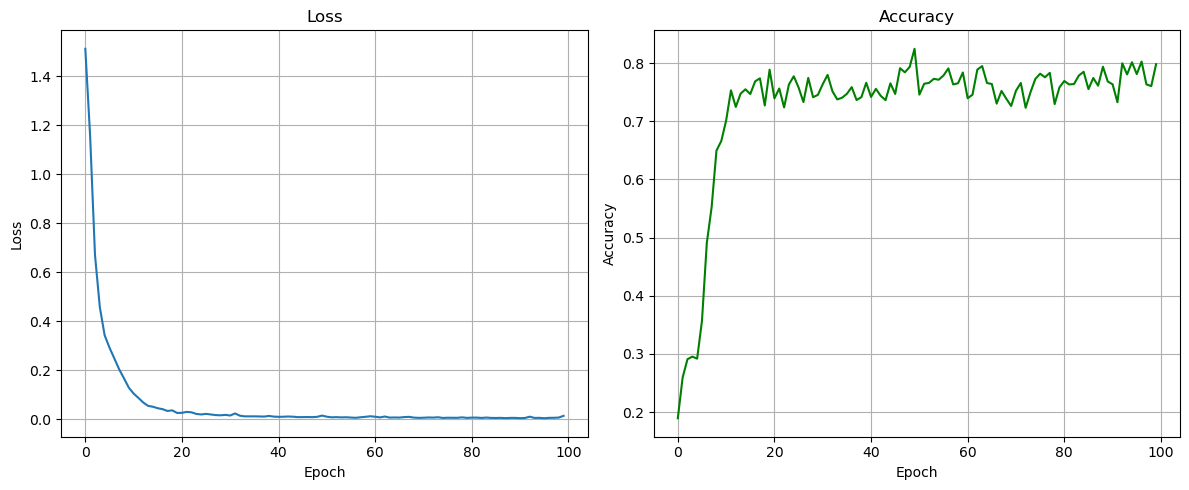

In [16]:
model = MyModel(input_features=10, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

device = 'cpu'
train_losses, val_accuracies, best_acc, best_precision, best_recall, best_f1 = train_model(
    model, train_loader, test_loader, device, epochs=100
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
class RepoSplitTimeSeriesDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5, mode="train", split_ratio=0.8):
        self.samples = []
        assert mode in ["train", "val"], "mode must be 'train' or 'val'"

        grouped = meta_df.groupby("Repo")

        for repo_id, group_indices in grouped.groups.items():
            # sort by time within each repo
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()

            total = len(sorted_idx)
            split_point = int(total * split_ratio)

            if total < timesteps:
                continue  # skip short repos

            if mode == "train":
                use_idx = sorted_idx[:split_point]
            else:  # val
                use_idx = sorted_idx[split_point:]

            # re-slide within the selected portion
            for i in range(len(use_idx) - timesteps + 1):
                window_idx = use_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                meta_seq = meta_df.loc[window_idx].iloc[-1].to_dict()
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    

timesteps = 5
train_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="train", split_ratio=0.1)
val_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="val", split_ratio=0.1)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch 1: loss = 1.6135, A = 0.2472, P = 0.2855, R = 0.2472, F1 = 0.2197
Epoch 2: loss = 1.5905, A = 0.3186, P = 0.2300, R = 0.3186, F1 = 0.2570
Epoch 3: loss = 1.5697, A = 0.3531, P = 0.3318, R = 0.3531, F1 = 0.3140
Epoch 4: loss = 1.5357, A = 0.4164, P = 0.4273, R = 0.4164, F1 = 0.3725
Epoch 5: loss = 1.5208, A = 0.4945, P = 0.4644, R = 0.4945, F1 = 0.4363
Epoch 6: loss = 1.4799, A = 0.5532, P = 0.5290, R = 0.5532, F1 = 0.4974
Epoch 7: loss = 1.4387, A = 0.5870, P = 0.4998, R = 0.5870, F1 = 0.5206
Epoch 8: loss = 1.3877, A = 0.6280, P = 0.5233, R = 0.6280, F1 = 0.5594
Epoch 9: loss = 1.2972, A = 0.6888, P = 0.6289, R = 0.6888, F1 = 0.6294
Epoch 10: loss = 1.2083, A = 0.7013, P = 0.6335, R = 0.7013, F1 = 0.6437
Epoch 11: loss = 1.0784, A = 0.7305, P = 0.7377, R = 0.7305, F1 = 0.6805
Epoch 12: loss = 0.9670, A = 0.7570, P = 0.6830, R = 0.7570, F1 = 0.7086
Epoch 13: loss = 0.8589, A = 0.7940, P = 0.7216, R = 0.7940, F1 = 0.7521
Epoch 14: loss = 0.7628, A = 0.8336, P = 0.7626, R = 0.8336,

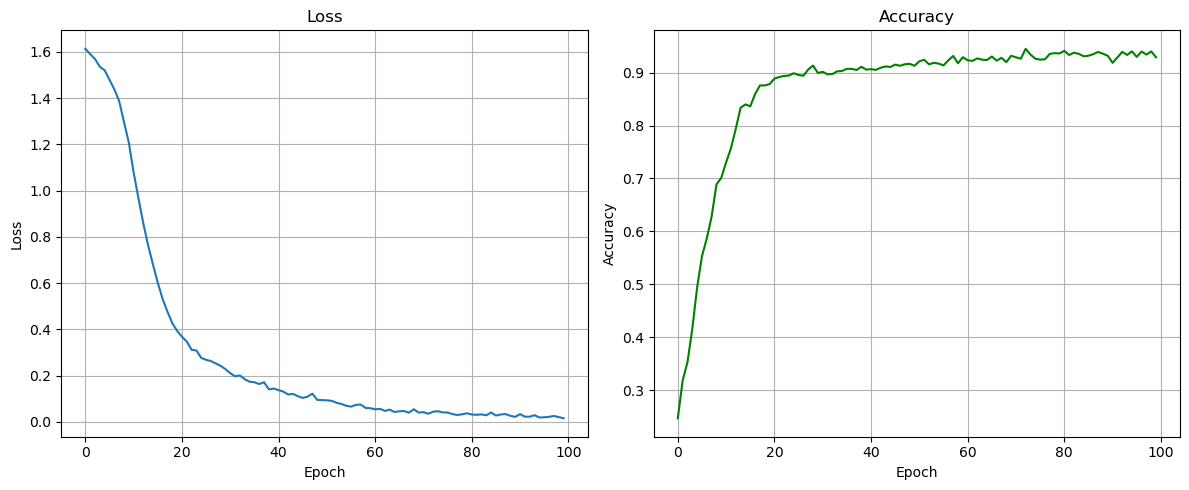

In [18]:
model = MyModel(input_features=10, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

device = 'cpu'
train_losses, val_accuracies, best_acc, best_precision, best_recall, best_f1 = train_model(
    model, train_loader, val_loader, device, epochs=100
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
print(y.value_counts(normalize=True))

Evaluate
1    0.284459
0    0.266693
4    0.237602
2    0.133151
3    0.078094
Name: proportion, dtype: float64


In [20]:
import numpy as np

def predict_with_uncertainty(model, x, runs=50, device='cpu'):
    model.eval()
    preds = []

    with torch.no_grad():
        for _ in range(runs):
            output = model(x.to(device))  # shape: (1, T, num_classes)
            prob = F.softmax(output, dim=-1)  # shape: (1, T, num_classes)
            preds.append(prob.cpu().numpy())

    preds = np.stack(preds, axis=0)  # shape: (runs, 1, T, num_classes)
    mean_pred = preds.mean(axis=0)[0]   # shape: (T, num_classes)
    std_pred = preds.std(axis=0)[0]     # shape: (T, num_classes)

    return mean_pred, std_pred  # one per timestep

In [21]:
def plot_prediction_with_uncertainty(mean_pred, std_pred, timestep=0, class_names=None):
    if class_names is None:
        class_names = [f'Class {i}' for i in range(mean_pred.shape[1])]

    probs = mean_pred[timestep]  # shape: (num_classes,)
    stds = std_pred[timestep]    # shape: (num_classes,)

    plt.figure(figsize=(5, 3))
    plt.bar(range(len(probs)), probs, yerr=stds, capsize=5, color='skyblue', alpha=0.8)
    plt.xticks(range(len(probs)), class_names)
    plt.ylabel("Predicted Probability")
    plt.title(f"Uncertainty at timestep {timestep}")
    plt.grid(axis='y')
    plt.show()

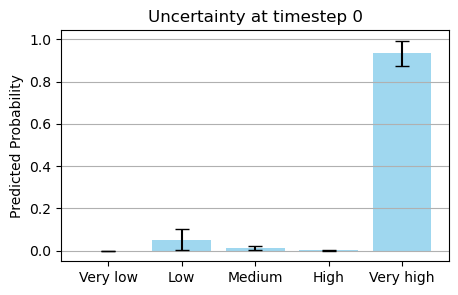

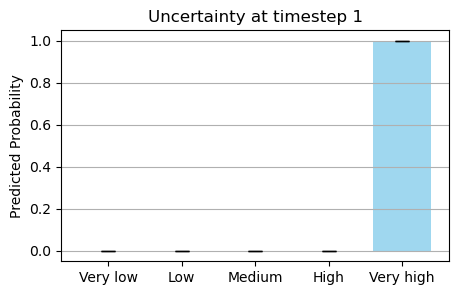

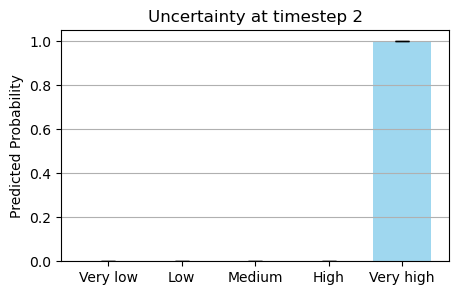

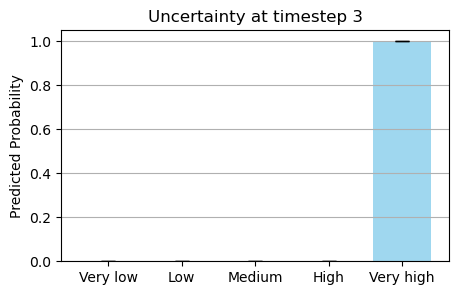

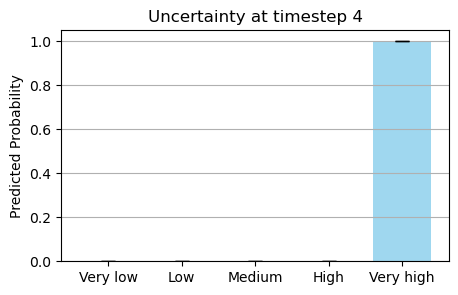

In [22]:
x_sample = val_dataset[0][0].unsqueeze(0)  # shape: (1, T, F)
mean, std = predict_with_uncertainty(model, x_sample, runs=10, device='cpu')
for timestep in range(5):
    plot_prediction_with_uncertainty(mean, std, timestep=timestep, class_names=["Very low", "Low", "Medium", "High", "Very high"])
# x_sample.shape

In [23]:
def bayesian_predictive_entropy(model, x, runs=10, device='cpu'):
    model.eval()
    predictions = []

    with torch.no_grad():
        for _ in range(runs):
            out = model(x.to(device))  # shape: (1, T, C)
            probs = F.softmax(out, dim=-1)  # shape: (1, T, C)
            predictions.append(probs.cpu().numpy())

    # shape: (runs, 1, T, C)
    preds = np.stack(predictions, axis=0)

    # average softmax predictions across runs
    mean_pred = preds.mean(axis=0)[0]  # shape: (T, C)

    # Entropy: H[p] = -sum p log p
    entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-12), axis=-1)  # shape: (T,)

    return mean_pred, entropy

In [24]:
def plot_entropy(entropy, title="Predictive uncertainty"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 4))
    plt.plot(entropy, marker='o', color='purple')
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

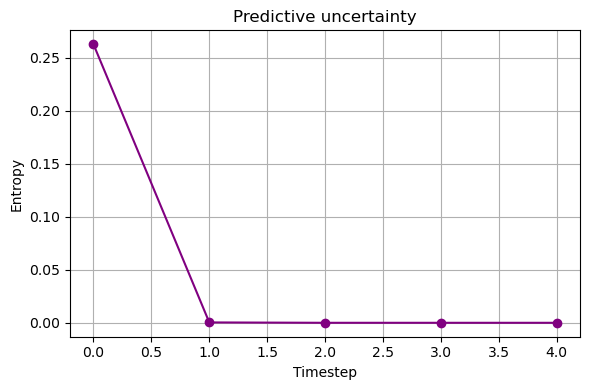

In [25]:
mean, entropy = bayesian_predictive_entropy(model, x_sample, runs=10, device='cpu')
plot_entropy(entropy)